# Gas Consumption for the Magallanes Region in Chile

In the following exercise we'll predict gas consumption for the Magallanes region for which we have historical data of 7 years, from 20th October 1995 until 31st December 2002.

## Importing Packages & Data

In [72]:
import numpy as np
import scipy as sp
import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_csv('consumo.csv', delimiter=';')

In [3]:
df['Fecha'] = pd.to_datetime((df.Año*10000+df.Mes*100+df.Dia).apply(str),format='%Y%m%d')

In [4]:
df_expl = df.set_index('Fecha')

## Data Exploration

We'll first take a quick look at the data to see if we can find any trends or patterns of interest.

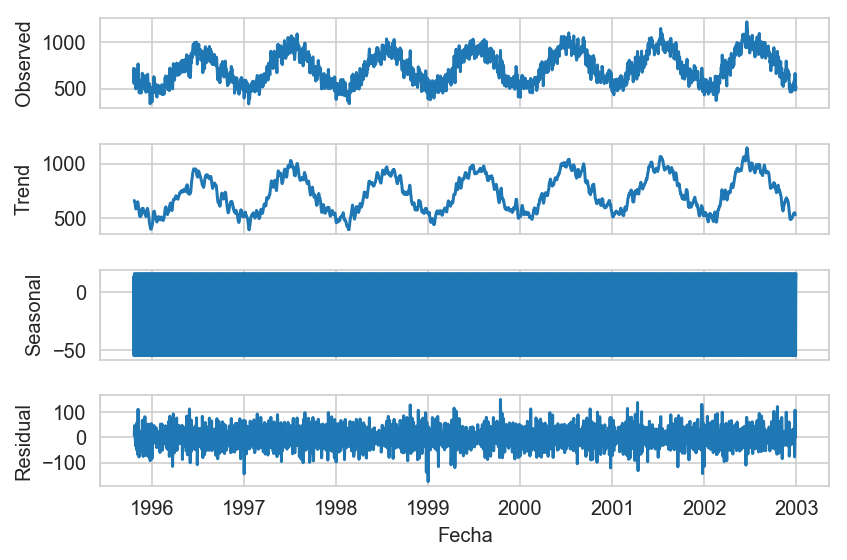

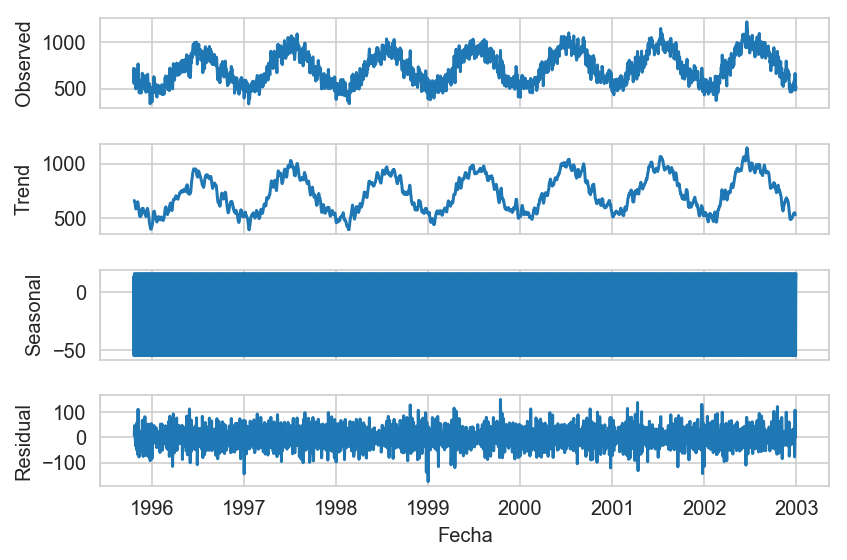

In [5]:
sm.tsa.seasonal_decompose(df_expl.Consumo,'additive').plot()

There doesn't seem to be a clear trend but we can appreciate there's a some seasonality, so we'll take a closer look.

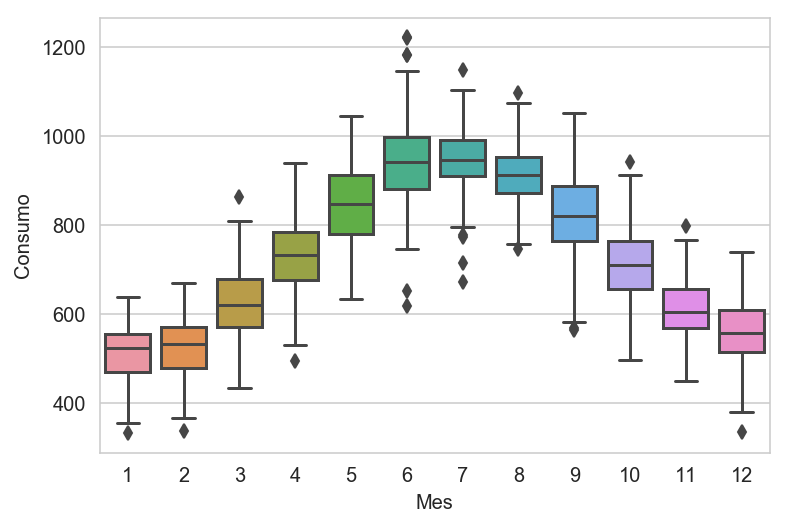

In [6]:
sns.boxplot(x='Mes',y='Consumo',data=df_expl)

When we see the data on a monthly basis we observe how the consumption of gas increases during the winter months reaching its peak between June and August.

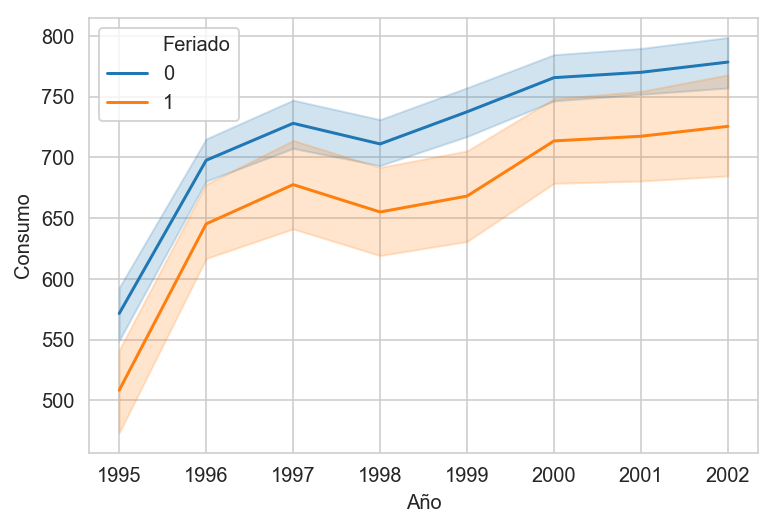

In [7]:
sns.lineplot(x='Año',y='Consumo',hue='Feriado',data=df_expl)

Also we can notice how there's a gap in consumption between business days and holidays which may help us later.

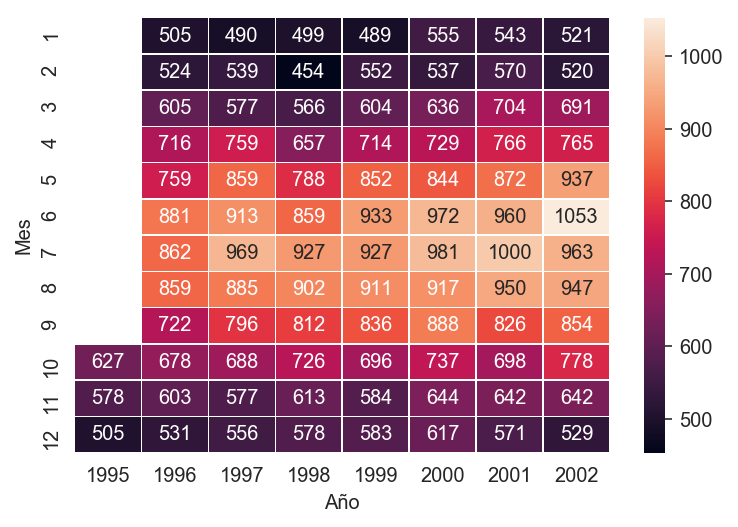

In [8]:
heat = df_expl.pivot_table(index='Mes',columns='Año',values='Consumo')
sns.heatmap(heat, linewidths=.25, annot=True, fmt=".0f")

Finally we can confirm there's no yearly trend but there's seasonality with period 1 (yearly).

In [94]:
df['Consumo'].mean()

725.5631178707224

## Data Modeling

For this problem we have to use a time series approach to model te data. Although there are some very good time series models like Seasonal Auto Regressive Integrated Moving Average (SARIMA) or Holt Winter's Exponential Smoothing (HWES), we'll use Facebook's Prophet ([paper](https://peerj.com/preprints/3190.pdf)) algorithm which deals with trend, seasonality, residuals and even holidays. For this purpose we'll compare the Prophet algorithm with and without holidays to see which works better.

Since we want to make daily, weekly and monthly forecasts, we'll use forecasting horizon of 30 days (1 month) to cover all cases. To compare both models we'll use cross validation with an initial training period of 1460 days (4 years) a rolling period of 90 days and the same forecasting horizon of 30 days. With this cross validation we'll obtain the Root Mean Squared Error (RMSE) and the Mean Absolute Error (MAE) for each prediction so that we can compare them in terms of precision.

### Facebook Prophet (without holidays)

In [61]:
df_ts1 = df[['Fecha','Consumo','Feriado']]
df_ts1.columns = ['ds','y','holiday']
df_ts1.drop(columns=['holiday']);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


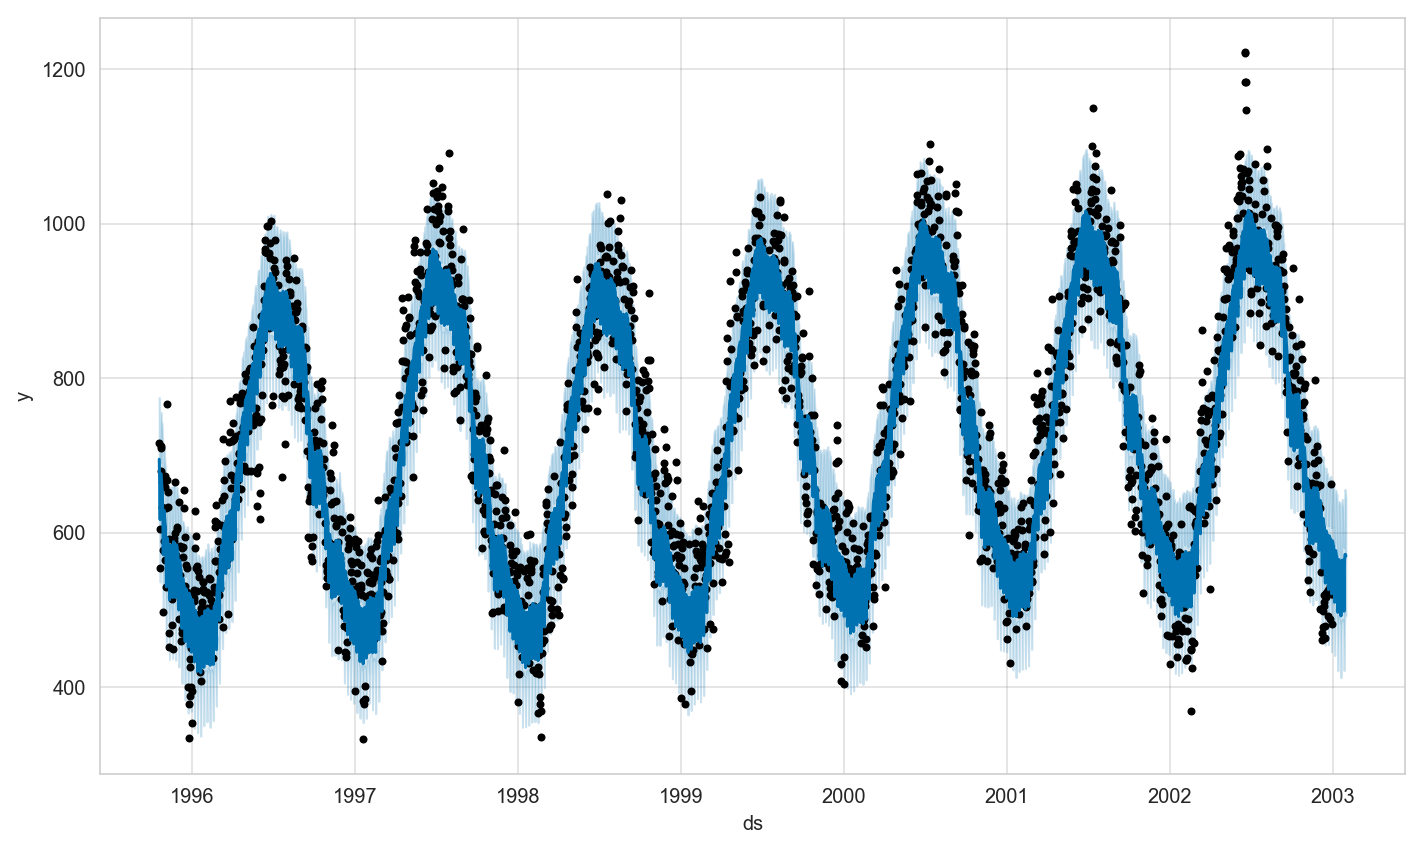

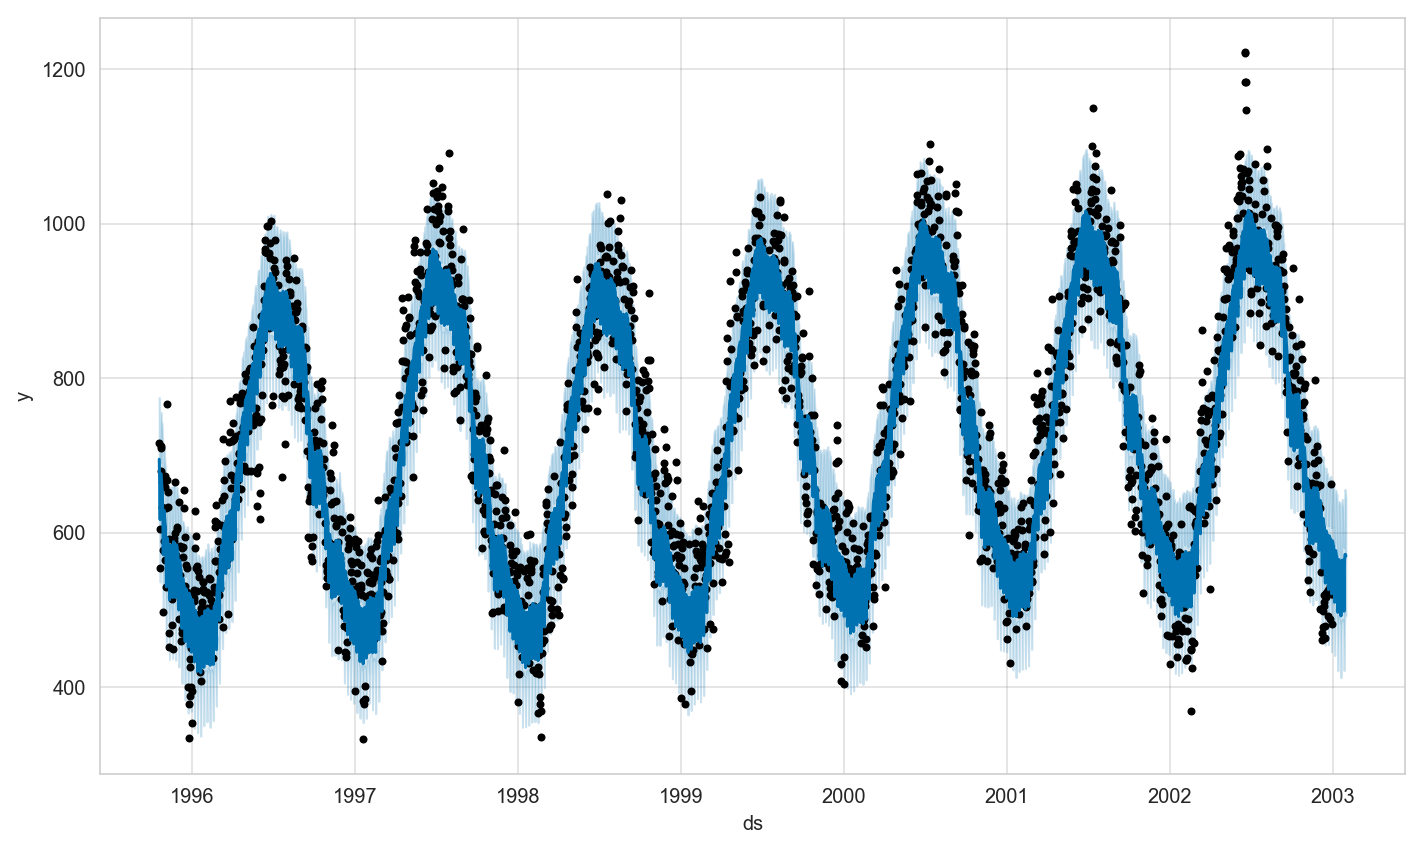

In [62]:
m1 = Prophet()
m1.fit(df_ts1)
future = m1.make_future_dataframe(freq='D', periods=30)
forecast = m1.predict(future)
m1.plot(forecast)

In [63]:
cv_results = cross_validation(m1, initial='1460 days', period ='90 days', horizon='30 days')
perf1 = performance_metrics(cv_results)

INFO:fbprophet:Making 13 forecasts with cutoffs between 1999-12-17 00:00:00 and 2002-12-01 00:00:00


In [64]:
perf1.tail()

,horizon,mse,rmse,mae,mape,coverage
23,26 days,4177.408239,64.632873,54.352425,0.085815,0.794872
24,27 days,4648.344576,68.178769,58.419363,0.090237,0.717949
25,28 days,4929.981065,70.213824,55.367114,0.082344,0.692308
26,29 days,4711.305124,68.638948,54.220760,0.075606,0.717949
27,30 days,4152.684700,64.441328,50.732286,0.069947,0.743590


In [65]:
avg_rmse1 = perf1['rmse'].mean()
avg_mae1 = perf1['mae'].mean()

print(avg_rmse1)
print(avg_mae1)

75.29466367768315
61.882168467210526


### Facebook Prophet (with holidays)

In [66]:
df_ts2 = df[['Fecha','Consumo','Feriado']]

holidays = df_ts2[df_ts2['Feriado'] == 1].Fecha.tolist()
holidays = pd.DataFrame({
  'holiday': 'Feriado',
  'ds': holidays,
  'lower_window': 0,
  'upper_window': 0,
})

df_ts2.columns = ['ds','y','holiday']
df_ts2.drop(columns=['holiday']);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


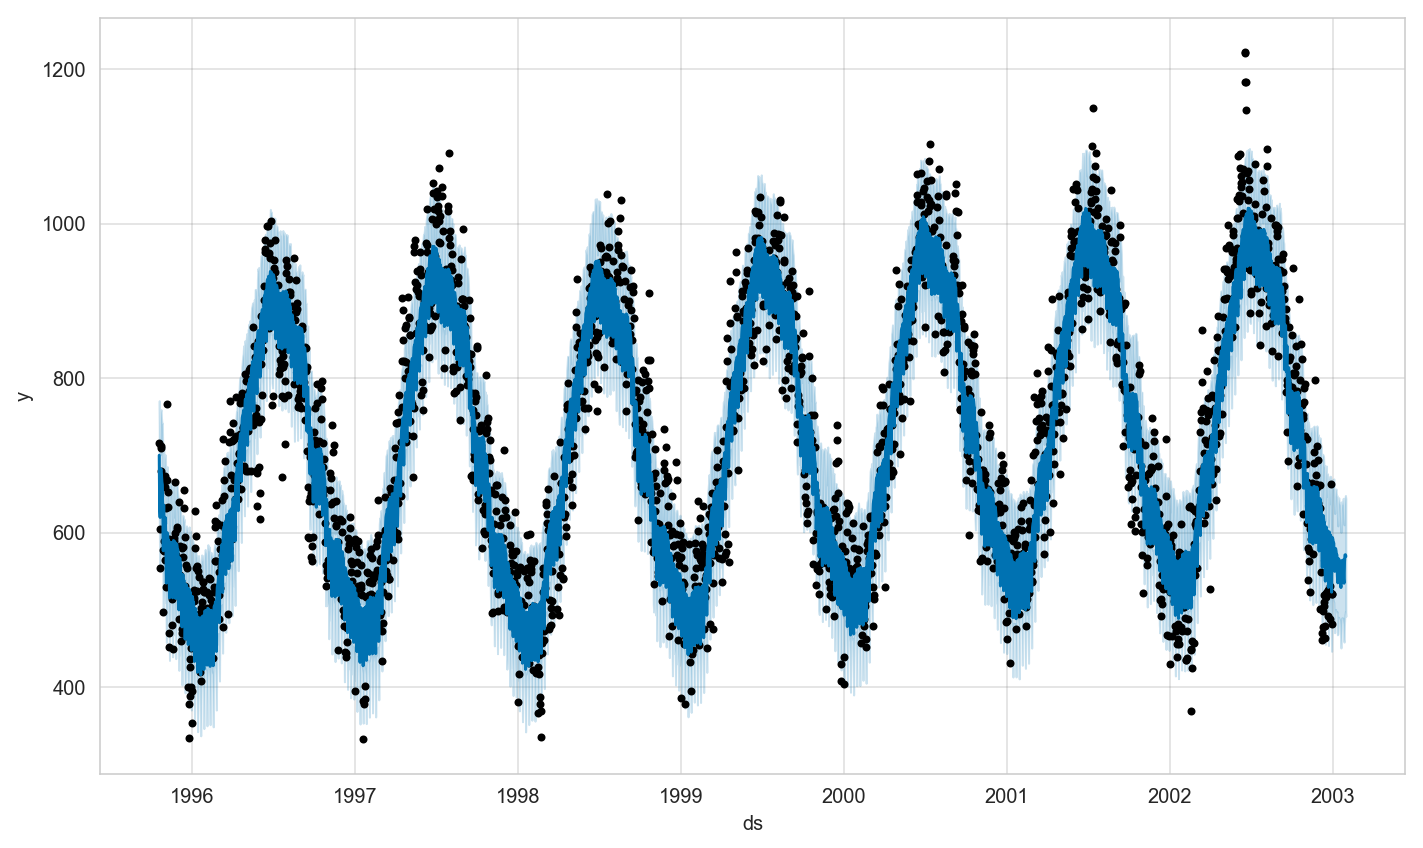

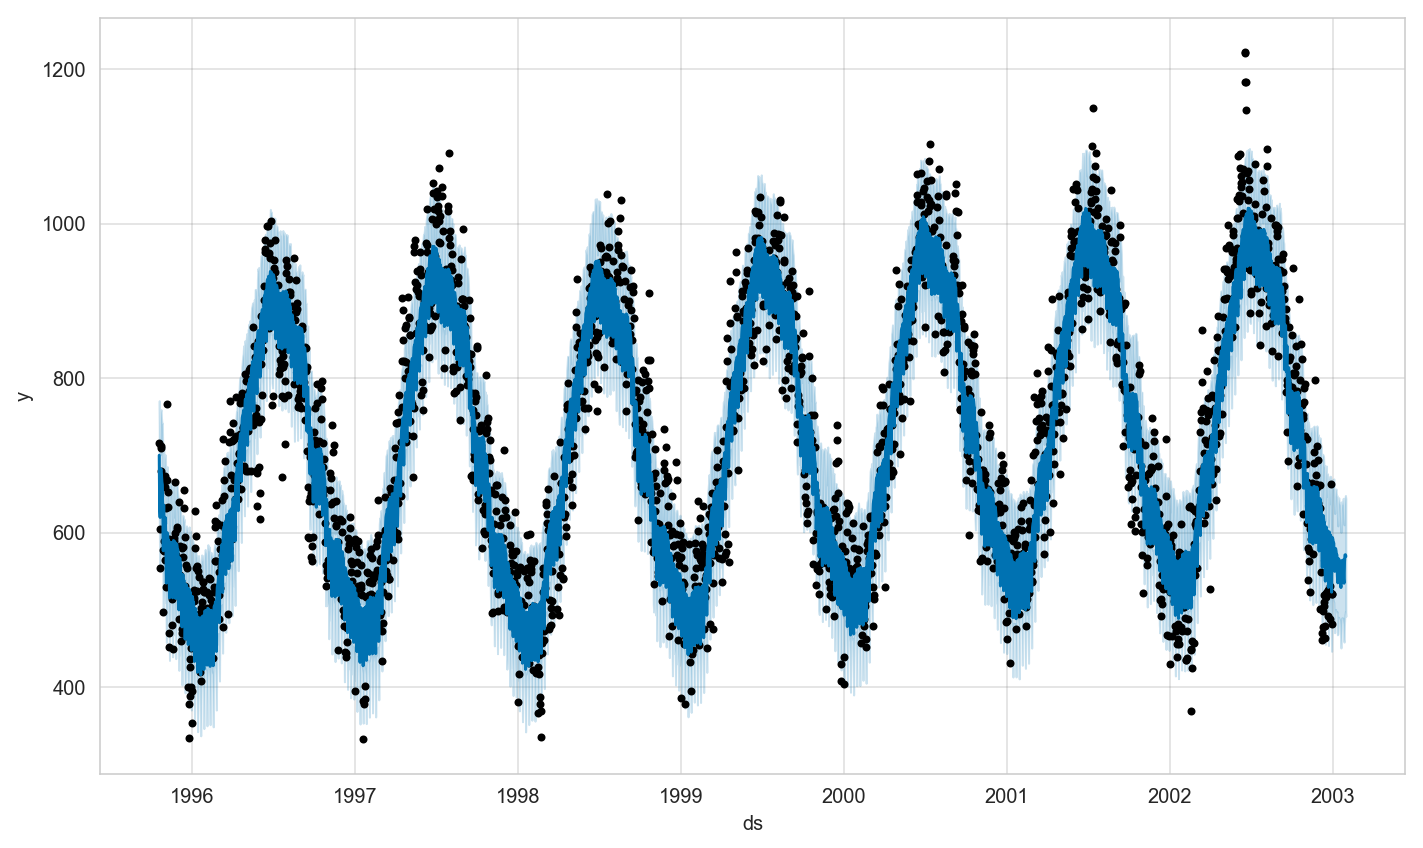

In [67]:
m2 = Prophet(holidays = holidays)
m2.fit(df_ts2)
future = m2.make_future_dataframe(freq='D', periods=30)
forecast = m2.predict(future)
m2.plot(forecast)

In [69]:
cv_results = cross_validation(m2, initial='1460 days', period ='90 days', horizon='30 days')
perf2 = performance_metrics(cv_results)

INFO:fbprophet:Making 13 forecasts with cutoffs between 1999-12-17 00:00:00 and 2002-12-01 00:00:00


In [70]:
perf2.tail()

,horizon,mse,rmse,mae,mape,coverage
23,26 days,3791.229397,61.572960,52.573793,0.082469,0.769231
24,27 days,4510.617869,67.161134,58.193160,0.089585,0.692308
25,28 days,4789.166168,69.203802,55.637572,0.082085,0.692308
26,29 days,4857.837322,69.698187,55.022966,0.077137,0.692308
27,30 days,4439.065537,66.626313,52.182849,0.072322,0.743590


In [71]:
avg_rmse2 = perf2['rmse'].mean()
avg_mae2 = perf2['mae'].mean()

print(avg_rmse2)
print(avg_mae2)

74.48004657358047
61.14186273525162


## Conclusions

Although the difference is small, the model that considers holidays has better RMSE and MAE value, with 74.48 and 61.14 respectively versus 75.29 and 61.88 for the plain model. Considering the average gas consumption across all years is 725.63, having an average RMSE of 74.48 is not bad considering it's around a 10% deviation from the real value.